In [10]:
!pip install tensorflow-datasets

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Verify TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Load the MNIST dataset from TensorFlow Datasets.
# as_supervised=True: Returns the dataset as (image, label) tuples, which is convenient.
# with_info=True: Also returns metadata about the dataset, like number of classes.
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Preprocessing  for Images and Labels with Normalization and One-Hot Encoding

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    #  Add Channel Dimension: Reshape (28, 28) grayscale images to (28, 28, 1).
    image = tf.expand_dims(image, axis=-1)

    # 3. One-Hot Encode Labels: Convert integer labels (e.g., 5) into a vector (e.g., [0,0,0,0,0,1,0,0,0,0]) when using 'categorical_crossentropy' as the loss function.
    # model predicts a probability distribution over all classes.
    num_classes = ds_info.features['label'].num_classes
    label = tf.one_hot(label, num_classes)
    return image, label

#Preprocessing and Preparation  for Training
#  We're using `tf.data` API for efficient data pipelines.

BATCH_SIZE = 128
# `map`: Applies our `preprocess_data` function to every element.
ds_train = ds_train.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
# `cache`: Caches data in memory after first iteration for faster subsequent epochs.
ds_train = ds_train.cache()
# `shuffle`: Randomizes the order of training examples to prevent the model from learning patterns based on data order.
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) # Shuffle buffer size = total examples
ds_train = ds_train.batch(BATCH_SIZE)
# `prefetch`: Overlaps data preprocessing and model execution, improving performance.
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache() # Cache test data too for faster evaluation
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

print(f"\nNumber of training samples: {ds_info.splits['train'].num_examples}")
print(f"Number of test samples: {ds_info.splits['test'].num_examples}")
print(f"Number of classes (digits): {ds_info.features['label'].num_classes}")

# Display shapes of the first batch to confirm preprocessing
for images, labels in ds_train.take(1):
    print(f"Shape of images in first training batch: {images.shape} (Batch Size, Height, Width, Channels)")
    print(f"Shape of labels in first training batch: {labels.shape} (Batch Size, Number of Classes - One-Hot Encoded)")


Number of training samples: 60000
Number of test samples: 10000
Number of classes (digits): 10
Shape of images in first training batch: (128, 28, 28, 1, 1) (Batch Size, Height, Width, Channels)
Shape of labels in first training batch: (128, 10) (Batch Size, Number of Classes - One-Hot Encoded)


In [14]:
# Define the CNN model using Keras Sequential API.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    # Max Pooling Layer (MaxPooling2D)Reduces the spatial dimensions of the feature maps, making the model

    tf.keras.layers.MaxPooling2D((2, 2)),# (2, 2): Size of the pooling window.

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

    # Second Max Pooling Layer
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten Layer

    tf.keras.layers.Flatten(),

    # First Dense (Fully Connected) Layer
    tf.keras.layers.Dense(64, activation='relu'),

    # Output Dense Layer
    # 10: Number of neurons equals the number of classes (digits 0-9).
    # activation='softmax': Softmax activation.
    # probabilities for all classes equals 1. The highest probability is the prediction.
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8480 - loss: 0.5185 - val_accuracy: 0.9772 - val_loss: 0.0666
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9796 - loss: 0.0655 - val_accuracy: 0.9833 - val_loss: 0.0515
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9862 - loss: 0.0453 - val_accuracy: 0.9871 - val_loss: 0.0384
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9881 - val_loss: 0.0332
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9908 - loss: 0.0283 - val_accuracy: 0.9860 - val_loss: 0.0421
Training complete.


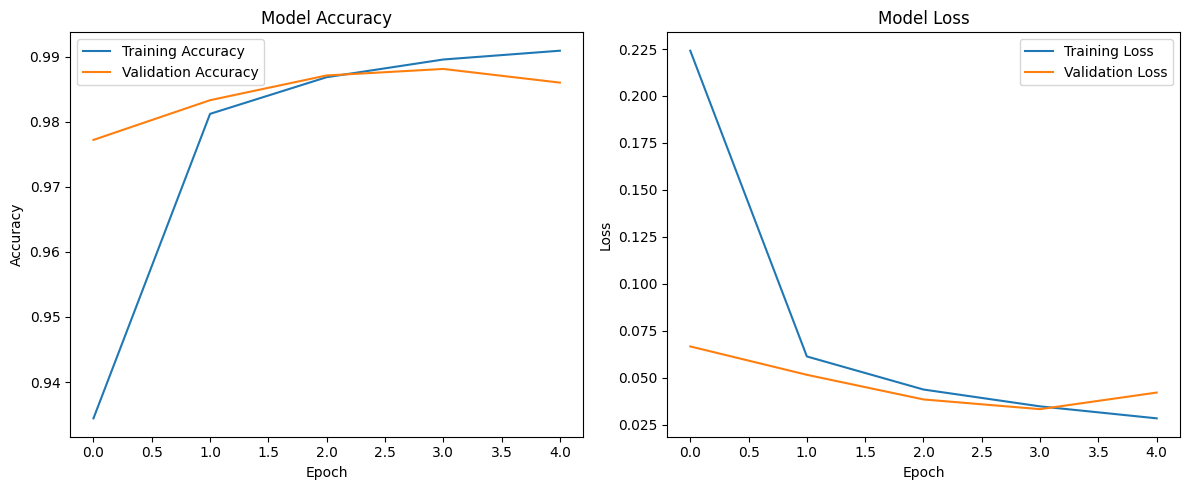

In [15]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Changed to categorical_crossentropy due to one-hot encoding
    metrics=['accuracy']
)


print("\nStarting model training...")
history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test # Use the preprocessed test set for validation during training
)
print("Training complete.")

# Plot training history (loss and accuracy over epochs)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Final Test Loss: 0.0421
Final Test Accuracy: 0.9860

SUCCESS! Test accuracy is above 95%. Great job!

Visualizing predictions for 5 sample images from the test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


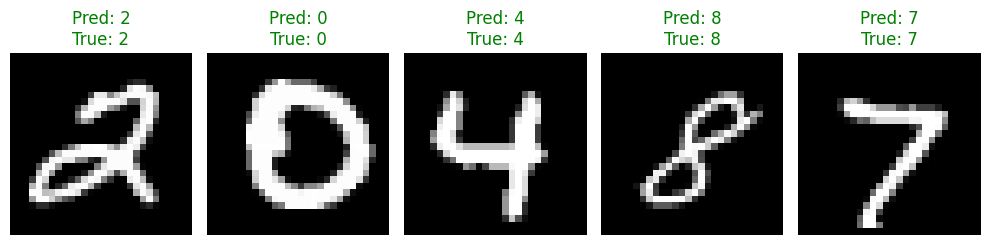

In [16]:
# Evaluate the model on the test dataset to get final performance metrics.
test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
print(f'\nFinal Test Loss: {test_loss:.4f}')
print(f'Final Test Accuracy: {test_accuracy:.4f}')

# Check if the accuracy requirement is met
if test_accuracy > 0.95:
    print("\nSUCCESS! Test accuracy is above 95%. Great job!")
else:
    print("\nATTENTION: Test accuracy is not yet above 95%. Consider training for more epochs or adjusting the model architecture.")

# Visualize Model Predictions on Sample Images


print("\nVisualizing predictions for 5 sample images from the test set:")
for images, labels_one_hot in ds_test.take(1): # Take one batch from the test dataset
    # Get predictions for the first 5 images in this batch
    predictions = model.predict(images[:5])

    # Convert predictions (probabilities) to predicted class labels (0-9)
    # Concept: `np.argmax` finds the index of the highest probability, which is our predicted digit.
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert one-hot encoded true labels back to integer labels for display
    true_labels = np.argmax(labels_one_hot.numpy()[:5], axis=1)

    plt.figure(figsize=(10, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        # Display the image remove the channel dimension for display if present
        plt.imshow(images[i].numpy().squeeze(), cmap='gray') # .squeeze() removes single-dimensional entries like the channel
        # Set title with predicted and true labels, coloring green for correct, red for incorrect
        plt.title(f'Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}',
                  color='green' if predicted_labels[i] == true_labels[i] else 'red')
        plt.axis('off') # Hide axes for cleaner image display
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()